In [ ]:
# piecewise linear mapping not suitable for dnn (very deep neural networks tend to suffer from gradient vanishing)

# NN summary
### Components
+ Dense > BatchNormalization > DropOut >SoftMax

### Optimizer
+ Adam

### Loss
+ BinaryCrossEntropy

### Metric
+ Accuracy (%)

In [ ]:
## Note on accuracy:
# FCNN has too many parameters (to train)，10000 samples are not enough (overfitting or sensitive)，
# thus validation loss>> train los.
# GNN has much fewer parameters，10000 samples are onough，validation loss converges fast
# Although training loss/accuracy is similar for 3 models, validation loss looks different
# Also the validation results look different for DNN in different trails
# Somehow like the polynomial fitting problem?

In [ ]:
import pickle
from os import path
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from time import time
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla P100-PCIE-16GB


In [ ]:
!nvidia-smi

Thu Feb 10 20:37:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118dc_quad_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix

filename='/content/drive/MyDrive/gnn/data/data_118_quad/118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

n_line = np.size(S_isf,0)

S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit

In [ ]:
# load data
x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_plimit_x.npy').transpose([2,0,1]).astype('float32')
y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_plimit_y.npy').transpose([1,0]).astype('float32')
W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy').astype('float32')
n_bus=x.shape[1]
x=np.reshape(x,(x.shape[0],-1))
print(x.shape)
print(y.shape)
# train val test split
x_total,x_test,y_total,y_test=train_test_split(x,y,test_size=0.15,random_state=23)
kf=KFold(n_splits=10,shuffle=True)
for train_index,val_index in kf.split(x_total):
  x_train=x_total[train_index]
  y_train=y_total[train_index]
  x_val=x_total[val_index]
  y_val=y_total[val_index]
  break
# data loader
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y,device):
        self.x=torch.from_numpy(x).float().to(device)
        self.y=torch.from_numpy(y).float().to(device)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx=idx.tolist()
        # Select sample
        return self.x[idx],self.y[idx]
params={'batch_size': 200,
        'shuffle': True,
        'num_workers': 0}
train=Dataset(x_train,y_train,device)
train_set=torch.utils.data.DataLoader(train,**params)
val=Dataset(x_val,y_val,device)
val_set=torch.utils.data.DataLoader(val,**params)

(16000, 472)
(16000, 118)


In [ ]:
class dnn(torch.nn.Module):
  def __init__(self,shape,dropout=0):
    super(dnn,self).__init__()
    layers=[]
    for idx in range(len(shape)-2):
      layers.extend([
        nn.Linear(shape[idx],shape[idx+1]),
        nn.ReLU(),
        nn.BatchNorm1d(shape[idx+1]),
        nn.Dropout(dropout)
      ])
    layers.append(nn.Linear(shape[-2],shape[-1]))
    self.features=nn.Sequential(*layers)
    # initialize
    for temp in self.features:
      if type(temp)==nn.Linear:
        torch.nn.init.normal_(temp.weight,mean=0,std=1)
  def forward(self,x):
    return self.features(x)
net=dnn([118*4,118*5,118*5,118*10,118*10,118*10,118*10,118]).to(device)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

number of params: 5657038


In [ ]:
# threshold function for p_g
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    # thresh=torch.tensor(thresh).double()
    # print(thresh,thresh.dtype)
    # print(x.dtype,x)
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    output=torch.where(x<left_thresh,0.,x)
    output=torch.where(output>right_thresh,right_thresh,output)
    # output=torch.where(output*output<thresh*thresh,output/thresh,output)
    return output

## define f-feasibility regularizer 

gen_pred_binary_cell = my_gen_pred_binary() # threshold function
def f_feas_reg(train_batch,pred_label,binary_thres,S,f_max):
  # train_batch,pred_label in device
  # params.to(device)

  # train_batch[:,2,:] # generator limit
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  # train_batch[:,1,:] # generator cost
  # profit = label1 - train_batch[:,1::3].transpose(0,1) # profit
  p_max=train_batch[:,0::4].transpose(0,1) - train_batch[:,1::4].transpose(0,1)
  quadratic_b=train_batch[:,2::4].transpose(0,1)
  quadratic_a=train_batch[:,3::4].transpose(0,1)
  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2

  gen_pred_binary = gen_pred_binary_cell(quadratic_center,binary_thres)
  p_inj = gen_pred_binary
  # p_inj = torch.mul(gen_pred_binary,train_batch[:,2::3].transpose(0,1)) # p_g
  # nodal injection = gen - load
  bus_inj = p_inj - train_batch[:,1::4].transpose(0,1)
  f = torch.matmul(S,bus_inj)
  f=torch.abs(f)
  # do not use torch.max
  f_penalty=torch.where(f>f_max,f-f_max,0.)
  # f_penalty = torch.max(f - f_max,0) # linear penalty
  # f_penalty = torch.exp(f - f_max) - 1 # exponential penalty
  return f_penalty


# define loss function
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1,train_batch,S,f_max):
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.02])).to(device) # locality
  lmda4=torch.from_numpy(np.array([0.001])).to(device) # f-feasibility

  binary_thres = 0.97 # P_g threshold for 0
  binary_thres = torch.tensor(binary_thres).to(device)    

  mse = loss_func(pred,label)
  linf = (pred-label).norm(p=float('inf'))
  # locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  f_penalty = f_feas_reg(train_batch,pred,binary_thres,S,f_max)
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse + lmda2*linf +lmda4*torch.sum(f_penalty) #+ lmda3*torch.mean(locality) # mean/sum over batch

In [ ]:
!nvidia-smi

Thu Feb 10 20:37:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |   1067MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_loss=[]
val_loss=[]
optimizer=torch.optim.Adam(net.parameters())
# loss_func=nn.MSELoss()
epochs=500
val_epoch=5

# early stop
tolerance=5
min_delta=1e-4
previous=0
W_tensor = torch.from_numpy(W).float().to(device)
t0=time()
for epoch in range(epochs):
  epoch_loss=0.0
  for x_batch_train,y_batch_train in train_set:
    optimizer.zero_grad()
    output=net(x_batch_train)
    # loss=loss_func(output,y_batch_train)
    loss=my_loss_func(output,y_batch_train,W_tensor,x_batch_train,S,f_max)
    loss.backward()
    epoch_loss+=loss.item()
    # update parameters of net
    optimizer.step()
  train_loss.append(epoch_loss/len(train_set.dataset))
  print("Epoch %d | Train loss: %.4f"%(epoch,train_loss[-1]))
  # val
  if epoch%val_epoch==0:
    net.eval()
    epoch_loss=0.0
    for x_batch_val,y_batch_val in val_set:
      output=net(x_batch_val)
      loss=my_loss_func(output,y_batch_val,W_tensor,x_batch_val,S,f_max)
      epoch_loss+=loss.item()
    val_avg=epoch_loss/len(val_set.dataset)
    if (epoch==0): previous=val_avg
    else:
      if previous-val_avg<min_delta:
        tolerance-=1
        if tolerance==0:
          break
      previous=val_avg
    print("Epoch %d | Eval loss: %.4f" %(epoch,val_avg))
    val_loss.append([epoch,val_avg])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t1=time()
print('Training time: %.4f'%(t1-t0))
path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_dnn.pickle'
torch.save(net.state_dict(),path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 | Train loss: 721.1901
Epoch 0 | Eval loss: 779.1388
Epoch 1 | Train loss: 649.0486
Epoch 2 | Train loss: 516.0456
Epoch 3 | Train loss: 353.6615
Epoch 4 | Train loss: 203.1043
Epoch 5 | Train loss: 96.9669
Epoch 5 | Eval loss: 180.8534
Epoch 6 | Train loss: 40.4154
Epoch 7 | Train loss: 17.9306
Epoch 8 | Train loss: 10.7803
Epoch 9 | Train loss: 8.4885
Epoch 10 | Train loss: 7.5088
Epoch 10 | Eval loss: 110.6098
Epoch 11 | Train loss: 6.9621
Epoch 12 | Train loss: 6.6464
Epoch 13 | Train loss: 6.4640
Epoch 14 | Train loss: 6.3119
Epoch 15 | Train loss: 6.2091
Epoch 15 | Eval loss: 99.7292
Epoch 16 | Train loss: 6.1426
Epoch 17 | Train loss: 6.1025
Epoch 18 | Train loss: 6.0650
Epoch 19 | Train loss: 6.0250
Epoch 20 | Train loss: 6.0192
Epoch 20 | Eval loss: 118.6476
Epoch 21 | Train loss: 5.9698
Epoch 22 | Train loss: 5.9636
Epoch 23 | Train loss: 5.9156
Epoch 24 | Train loss: 5.9155
Epoch 25 | Train loss: 5.9025
Epoch 25 | Eval loss: 91.2802
Epoch 26 | Train loss: 5.9089
Epoc

13


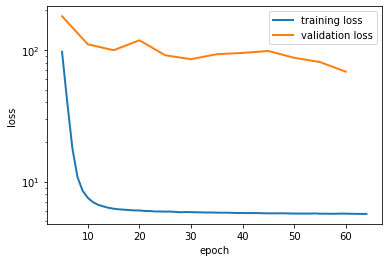

In [ ]:
# plot loss
val_len = len(val_loss)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = val_loss[i][0]
  val_plt[1,i] = val_loss[i][1]

plt.figure()
plot_idx = np.arange(np.size(train_loss))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],train_loss[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

In [ ]:
test_feed=torch.from_numpy(x_test).float().to(device)
output=net(test_feed)
y_pred=output.cpu().detach().numpy()

L2 mean: 0.045797567856002676 L_inf mean: 0.051048396021286226


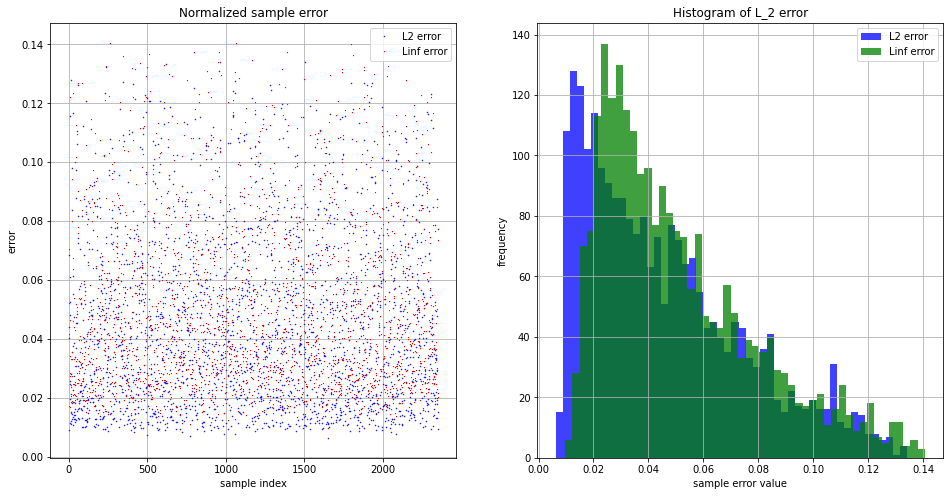

In [ ]:
n_test=y_test.shape[0]
err_L2=np.zeros(n_test)
err_Linf=np.zeros(n_test)
for i in range(n_test):
  err_L2[i]=np.linalg.norm(y_test[i,:]-y_pred[i,:])/np.linalg.norm(y_test[i,:])
  err_Linf[i]=np.max(np.abs(y_test[i,:]-y_pred[i,:]))/np.max(np.abs(y_test[i,:]))

# filter outliers
L2_thresh=np.argsort(err_L2)[:-50]
Linf_thresh=np.argsort(err_Linf)[:-50]
err_L2_filter=[err_L2[temp] for temp in range(len(err_L2)) if temp in L2_thresh]
err_Linf_filter=[err_Linf[temp] for temp in range(len(err_Linf)) if temp in Linf_thresh]

err_L2_mean = np.mean(err_L2_filter)
err_Linf_mean = np.mean(err_Linf_filter)
print('L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2_filter,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf_filter,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2_filter, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf_filter, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [ ]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
print(load_data.shape)
n_sample = load_data.shape[0]

x_val_feed = torch.from_numpy(load_data).float()
x_val_feed = x_val_feed.to(device)
print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

y_pred = net(x_val_feed) # predict the corredponding LMP

y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
y_pred1 = torch.squeeze(y_pred1,1).numpy()
print('reshaped size',y_pred1.shape)

(16000, 472)
Dataset size: torch.Size([16000, 472])
Number of validation points::  16000
output size torch.Size([16000, 118])
reshaped size (16000, 118)


In [ ]:
y_pred1.shape

(16000, 118)

In [ ]:
y.shape

(16000, 118)

In [ ]:
gen_cost0 = x[:,2::4].copy()
lmp_data = y.copy()

quadratic_a = x[:,3::4].copy()

profit_pred = y_pred1 - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=((y_pred1-gen_cost0)/(quadratic_a+1e-10)/2).transpose()
profit_true=((lmp_data-gen_cost0)/(quadratic_a+1e-10)/2).transpose()
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

0.00038146973
0.00799942
0.0009803402
0.0032806674


* Save results

In [ ]:
import pickle

In [ ]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [ ]:
gen_limit0 = x[:,2::4].transpose().copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 16000)
<class 'numpy.ndarray'> 118 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]


In [ ]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

(1888000,)


In [ ]:
print(np.min(p_pred_sort),np.min(p_true_sort))

-162483460000000.0 -19.686697


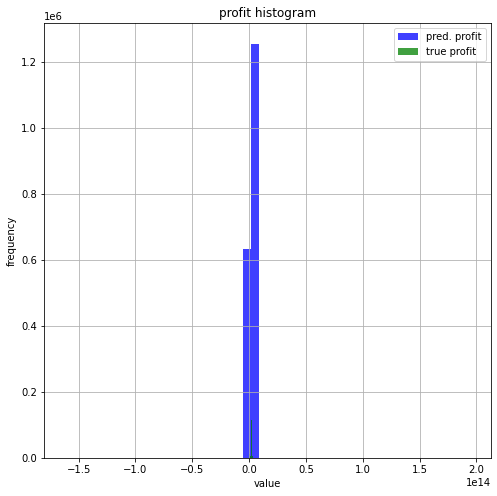

In [ ]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < -binary_thres:
#       gen_pred_binary[j,i] = 0
#     else:
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < -binary_thres_true:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [ ]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(118, 16000)
(472, 2400) (472, 16000)


 # Test flow feasibility

In [ ]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x[:,0::4].transpose().copy() # upper
binary_thres_lo = x[:,1::4].transpose().copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1::4].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [ ]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj_true),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

2060872.9686069917 2060872.9686069917
-496508.5499823019 69129736.0 -496508.5499823019


## injection accuracy

(118, 16000) (118, 16000)
mean p_inj l2 err: 0.1443759441856168


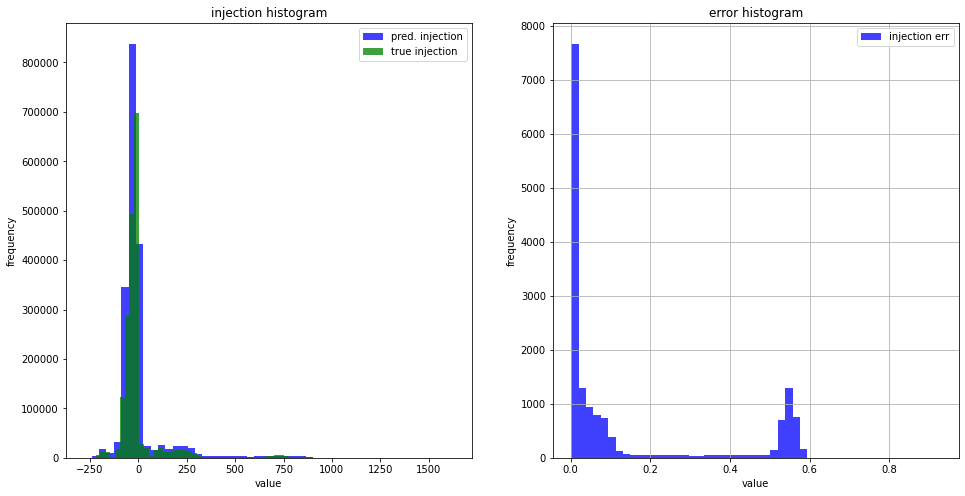

In [ ]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

* Calculate flow

In [ ]:
n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
f_max = f_max.cpu().detach().numpy()
f_binary = (np.abs(flow_est)-f_max > 0.03)
f_binary0 = (np.abs(flow_est0)-f_max > 0.03)

In [ ]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

44971 31607
0.01511122311827957 0.010620631720430108


In [ ]:
f_max_numpy = f_max.copy()

In [ ]:
a= np.asarray([[1,2,1],[2,2,1]])
b = np.asarray([1,1,1])
c = (a-b>0)
print(c)
print(np.sum(c))

[[False  True False]
 [ True  True False]]
3


In [ ]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))



max sample pred: 27
max line pred: 11879
max sample true: 6
max line true: 16000
